In [55]:
from langgraph.graph import StateGraph, START, END
from typing import TypedDict
from langchain_openai import ChatOpenAI
from dotenv import load_dotenv
from langgraph.checkpoint.memory import InMemorySaver

In [56]:
import os

from langchain_ollama import ChatOllama


load_dotenv()

OLLAMA_HOST = os.getenv("OLLAMA_HOST")
OLLAMA_MODEL = os.getenv("OLLAMA_MODEL")
model = ChatOllama(
        model=OLLAMA_MODEL,
        base_url=OLLAMA_HOST,
        temperature=0.2,        # critical for factual stability
        # num_predict=800,        # max tokens to generate
        timeout=60              # avoid hanging workers
    )

In [57]:
class JokeState(TypedDict):
    joke: str
    topic: str
    explanation: str

In [58]:
def generate_joke(input: JokeState) -> JokeState:
    topic = input["topic"]
    prompt = f"Tell me a funny joke about {topic} in less than 20 words."
    response = model.invoke(prompt)
    joke = response.content.strip()

    return {
        "joke": joke,
        "topic": topic,
    }

In [59]:
def generate_explanation(input: JokeState) -> JokeState:
    joke = input["joke"]
    prompt = f"Explain why the following joke is funny in less than 50 words: {joke}"
    response = model.invoke(prompt)
    explanation = response.content.strip()

    return {
        "joke": joke,
        "topic": input["topic"],
        "explanation": explanation
    }

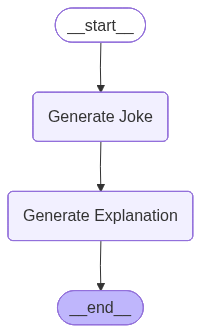

In [60]:
graph = StateGraph(JokeState)
checkpoint_saver = InMemorySaver()
graph.add_node(
    "Generate Joke",
    generate_joke
)
graph.add_node(
    "Generate Explanation",
    generate_explanation,
)

# add edges
graph.add_edge(START, "Generate Joke")
graph.add_edge("Generate Joke", "Generate Explanation")
graph.add_edge("Generate Explanation", END)

workflow = graph.compile(checkpointer=checkpoint_saver)
workflow

In [61]:
thread = '1'
config = {
    "configurable" : {
        "thread_id": "1"
    }
}

workflow.invoke(
    {
        "topic": "computers"
    },
    config=config
)

{'joke': 'My computer crashed and said, "I need a break." I replied, "You’re not the only one!" 😂',
 'topic': 'computers',
 'explanation': 'The humor lies in the pun: the computer "needs a break" literally (crashed) and figuratively (a pause), mirroring human exhaustion. The punchline twists the situation, making the user’s reply relatable and witty—both computer and human are "tired," blending tech frustration with everyday humor.'}

In [62]:
workflow.get_state(config)

StateSnapshot(values={'joke': 'My computer crashed and said, "I need a break." I replied, "You’re not the only one!" 😂', 'topic': 'computers', 'explanation': 'The humor lies in the pun: the computer "needs a break" literally (crashed) and figuratively (a pause), mirroring human exhaustion. The punchline twists the situation, making the user’s reply relatable and witty—both computer and human are "tired," blending tech frustration with everyday humor.'}, next=(), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0f6925-5b46-610c-8002-4184ee9cbee1'}}, metadata={'source': 'loop', 'step': 2, 'parents': {}}, created_at='2026-01-21T06:28:01.202779+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0f6925-514c-656a-8001-ce129c251cf0'}}, tasks=(), interrupts=())

In [63]:
thread = '2'
config1= {
    "configurable" : {
        "thread_id": "2"
    }
}

workflow.invoke(
    {
        "topic": "pizza"
    },
    config=config1
)

{'joke': 'Why did the pizza go to therapy?  \nIt had deep-dish issues! 🍕😄',
 'topic': 'pizza',
 'explanation': 'The joke is funny because "deep-dish" sounds like "deep issues," playing on the double meaning. A pizza\'s "deep-dish" refers to its thick, deep crust, but humorously, it\'s also a pun on emotional problems, making the pizza\'s need for therapy absurd and clever.'}

In [64]:
workflow.get_state(config1)

StateSnapshot(values={'joke': 'Why did the pizza go to therapy?  \nIt had deep-dish issues! 🍕😄', 'topic': 'pizza', 'explanation': 'The joke is funny because "deep-dish" sounds like "deep issues," playing on the double meaning. A pizza\'s "deep-dish" refers to its thick, deep crust, but humorously, it\'s also a pun on emotional problems, making the pizza\'s need for therapy absurd and clever.'}, next=(), config={'configurable': {'thread_id': '2', 'checkpoint_ns': '', 'checkpoint_id': '1f0f6925-687b-6f0a-8002-0b18944edfde'}}, metadata={'source': 'loop', 'step': 2, 'parents': {}}, created_at='2026-01-21T06:28:02.588001+00:00', parent_config={'configurable': {'thread_id': '2', 'checkpoint_ns': '', 'checkpoint_id': '1f0f6925-5f79-653b-8001-a785abf2b0d7'}}, tasks=(), interrupts=())